<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/MeasuredNoiseGP/examples/MeasuredNoiseGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measured and Predictive Noise Gaussian Process

*Prepared by Maxim Ziatdinov (January 2024)*

In [2]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 7.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import gpax

gpax.utils.enable_x64()

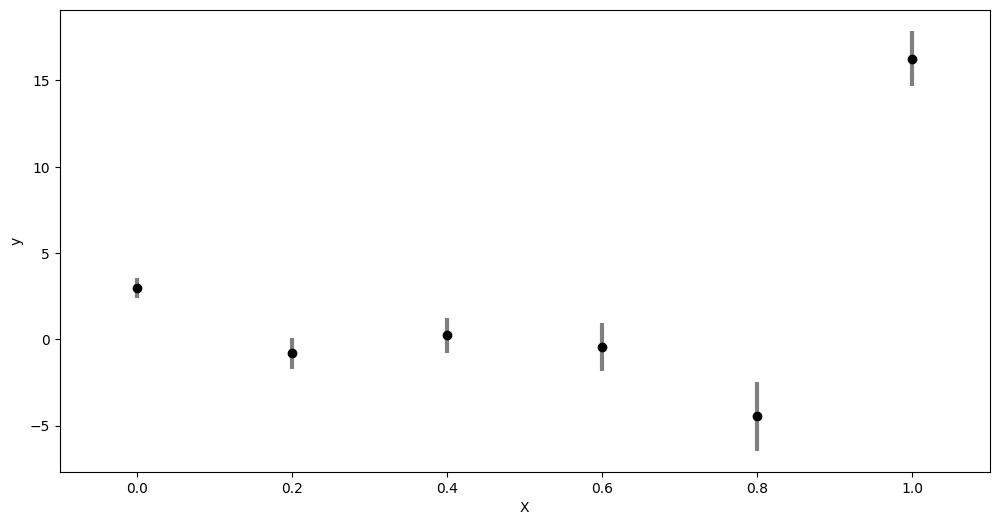

In [126]:
np.random.seed(1)

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)

# Function to generate variable noise based on X
def variable_noise(x):
    return 0.5 + 2 * x

# Generate X values
X = np.linspace(0, 1, 6)
#X = np.random.uniform(0, 1, 10)
num_measurements = 10  # Number of measurements per X

# Generate multiple noisy Y measurements for each X with variable noise
y_measurements = np.array([forrester_function(x) + np.random.normal(0, variable_noise(x), num_measurements) for x in X])

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
measured_noise = np.var(y_measurements, axis=1)

# Plotting with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    X, y, yerr=np.sqrt(measured_noise), fmt='o', color='black', ecolor='grey',
    elinewidth=3, capsize=0)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(-0.1, 1.1)
plt.show()

In [134]:
# Get random number generator keys
key1, key2 = gpax.utils.get_keys()

# Initialize model
model = gpax.MeasuredNoiseGP(1, "Matern")

# Train
model.fit(key1, X, y, measured_noise)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 617.00it/s, 7 steps of size 6.68e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.12      0.05      0.11      0.04      0.19   1259.94      1.00
    k_scale     26.24     12.94     23.17      9.97     45.17   1095.03      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



In [135]:
# Create a denser set of points
X_test = np.linspace(0, 1, 100)

# Make a prediction
y_pred, y_sampled = model.predict(key2, X_test, noise_prediction_method='linreg', n=100)

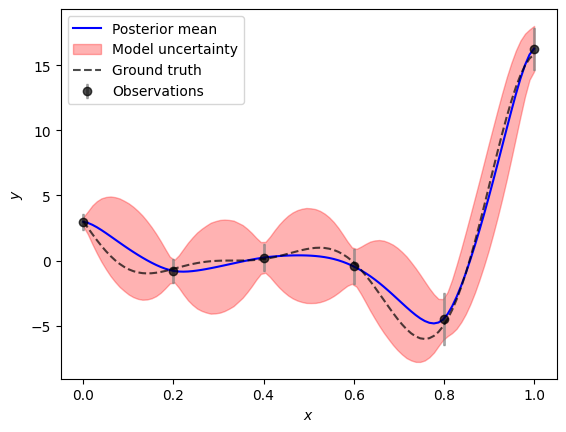

In [136]:
# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.errorbar(
    X, y, yerr=np.sqrt(measured_noise), fmt='o', color='black', ecolor='grey',
    alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.plot(X_test, forrester_function(X_test), '--', label='Ground truth', c='k', alpha=0.7, zorder=2)
ax.legend(loc='best')

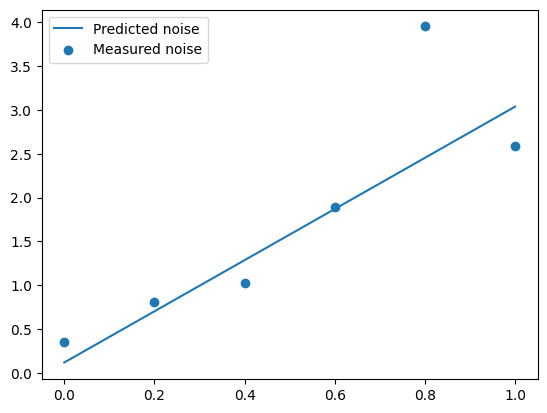

In [137]:
# Plot predicted (and measured) noise
plt.plot(X_test, model.noise_predicted, label="Predicted noise")
plt.scatter(X, measured_noise, label="Measured noise")
plt.legend()